# Peak Finder

This search algorithm has been designed for the detection and grouping of time-domain electromagnetic (TEM) data anomalies measured along
flight lines.
Detection markers can be exported to Geoscience ANALYST, along with various metrics for characterization and targeting:

  <img align="right" width="50%" src="./images/peak_finder_app.png">
  
- Amplitude
- Dip direction
- Mad Tau (TEM data only)
- Anomaly skewness

While initially designed for TEM data, the same application can be used for the characterization of anomalies of mixed data types (e.g. magnetics, gravity, dem, etc.).


  

New user? Visit the [Getting Started](../installation.rst) page.

## Application
The following sections provide details on the different parameters controling the application. Interactive widgets shown below are for demonstration purposes only.

In [1]:
from geoapps.processing import PeakFinder

app = PeakFinder(h5file=r"../../../assets/FlinFlon.geoh5")
app.main

C:\Users\dominiquef\AppData\Local\Continuum\anaconda3\envs\geoapps\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60584 instead
  http_address["port"], self.http_server.port


## Project Selection

Select and connect to an existing **geoh5** project file containing data. 

In [2]:
app.project_panel

See the [Project Panel](base_application.ipynb#Project-Panel) page for more details.

## Object/Data Selection

List of `Curve` objects available containing line data. Multiple data channels and/or data groups can be selected. 

In [3]:
app.data_panel

### Flip Y-axis

Option to invert the data profile by a -1 multiplication. Useful for the detection of lows instead of highs.

In [4]:
app.flip_sign

ToggleButton(value=False, button_style='warning', description='Flip Y (-1x)')

## TEM data

Flag the selected data to be Time-Domain EM data. 

In [5]:
app.tem_box

This option enables the [TEM System](#TEM-System), [Time Groups](#Time-Groups) and [Decay Curve](#Decay-Curve) panels.

### TEM System

List of available TEM systems.
The application will attempt to assign the *Survey Type* based on
known channel names (e.g. *Sf* => *VTEM*).

In [6]:
app.system_options

Assigning the right time to each data channel is important to the tau calculation. 

### Time Groups

Pre-define groups of time channels for the labeling of anomalies. For example, anomalies found in both the `early` and `middle` time groups are labeled as `early+middle` with the corresponding color code. 

See the [Methodology](#Methodology) section for details on the grouping.

In [7]:
app.groups_panel

### Decay Curve

Plot of peak values as a function of time for the nearest anomaly to the [Center](#Center) location.

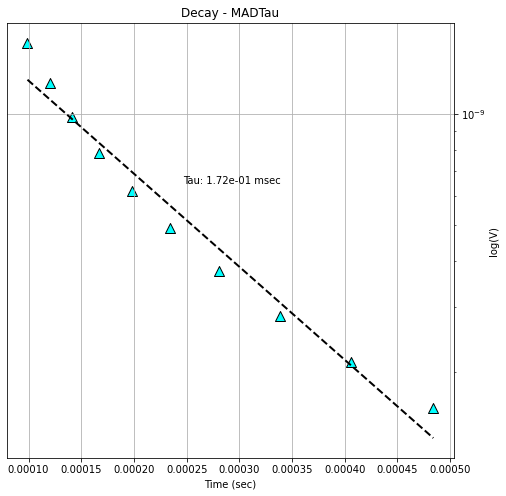

In [2]:
app.decay_figure


- This pseudo-decay curve can be used for the calculation of the `Slanted Tau`, or `Mad Tau`, as defined by the slope of the linear fit of log( `dB/dt`(V)) as a function `time` (s). 

    \begin{equation}
    \tau = \cot(\theta) \approx \frac{\Delta t}{\Delta log(dB/dt)}
    \end{equation}
    
    where $\Delta$ denotes the varation of time $t$ and $dB/dt$ over the selected group of time channels.   

- The time constant contains information on both the size and conductivity of the target. If independent information is available on the size of the target, then the time constant can be used to estimate conductance: 

    - Sphere  $\tau = \frac{\sigma \mu r^2}{\pi^2}$
    - Cylinder  $\tau = \frac{1.71 \sigma \mu r^2}{\pi^2}$
    - Plate  $\tau = \frac{2 t \sigma \mu l}{\pi^2}$

where $r$=radius, $t$=thickness, $l$=length, $\sigma$=conductivity, $\mu$=$4\pi\;10^{-7}$ ([Nabighian & Macnea, 1991](https://library.seg.org/doi/epdf/10.1190/1.9781560802686.ch6)).

## Line Selection

Selection of a channel representing the line identifier and specific line number.

In [9]:
app.lines.main

The detection algorithm and filtering parameters are applied immediately to the selected line as a test dataset.

## Profile Plot

Data profile plot with detected anomalies color coded by data groups. 

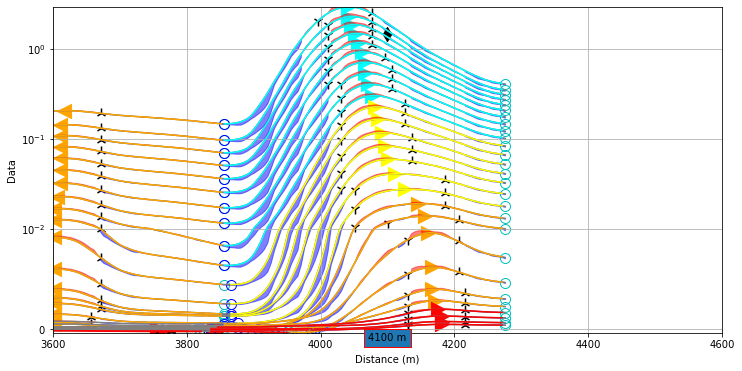

In [10]:
app.figure

Anomalies are detected when a peak (maximum) can be found between two lows (minimum) and two inflection points. 
Triangles marking the peaks position point in the estimated dip direction determined by:

- (TEM data) the peak migration direction
- (None-TEM) the skew direction

## Visual Parameters

Parameters controlling the [Profile Plot](#Profile-Plot).

In [11]:
app.visual_parameters

### Center
Position of the plotting window along the selected line.

### Width
Width of the plotting window

### X-axis label
Units displayed along the x-axis

### Y-axis scaling
Normalization of the data displayed along the Y-axis

### Symlog
Symmetric logarithmic option such that both positive and negative data can be displayed in log space.

#### Linear threshold

Limits for the log scale plot around zero. Values between the (+/-) threshold are plotted in linear scale. 

## Detection parameters

Parameters controlling the filtering and grouping of positive peak anomalies.

In [12]:
app.detection_parameters

<img align="center" width="75%" src="./images/peak_finder_parameters.png">


### Minimum Amplitude ($\delta_A$)

Threshold value for filtering small anomalies:

\begin{equation}
\delta_A = \|\frac{d_{max} - d_{min}}{d_{min}}\| * 100
\end{equation}

Set as a percent (%) of the data anomaly over its minimum value.


### Minimum Data Value ($\delta_d$)

Minimum absolute data value used by the algorithm:
\begin{equation}
d_i = 
\begin{cases}
d_i & \;\text{for } d_i > \delta_d \\
nan & \;\text{for } d_i \leq \delta_d\\
\end{cases}
\end{equation}

### Minimum Width

Minimum anomaly width (m) as measured from start to end (consecutive lows).


### Maximum Peak Migration

Threshold applied on the grouping of anomalies based on the lateral shift of peaks.

### Minimum number of channels

Minimum number of data channels required to form a group.


<img align="right" width="50%" src="./images/peak_smoothing.png">


### Smoothing

Parameter controlling the running mean averaging:

$d_i = \frac{1}{N}\Large{\sum}_{j=-\frac{N}{2}}^{\frac{N}{2}}d_{i+j}$

where `N` is the number of along line neighbours used for the averaging. The averaging becomes one sided at both ends of the profile. Positive (blue) and negative (red) residuals between the original and smoothed profile are shown for reference.


### Use residual

Option to use the residual between the recorded and smoothed data. Useful to highlight smaller anomalies within larger trends.


## Methodology

Anomalies are identified from the detection of maximum, minimum and inflection points, calculated from the first and second order
derivatives of individual time profiles.
[Detection Parameters](#Detection-Parameters) are available for filtering and grouping of co-located anomalies.
Manual adjustement of these parameters can first be done on a windowed portion of selected lines. Selected parameters
are then applied to all lines using [Dask](https://dask.org/) parallel processes.
The algorithm relies on the [Numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html) routine for the calculation of derivatives in
the Fourier domain.

In [13]:
import matplotlib.pyplot as plt
app.figure.savefig("images/peak_finder_thumbnail.png", dpi=300, bbox_inches='tight')